In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()  # файл kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamillagalimullina","key":"b2442d46e3b3612a4e9e3e9ac5647060"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c dl-2025-competition-1

In [6]:
!unzip dl-2025-competition-1.zip -d data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/data/train/48/1439.png  
  inflating: data/data/train/48/1440.png  
  inflating: data/data/train/48/1441.png  
  inflating: data/data/train/48/1442.png  
  inflating: data/data/train/48/1443.png  
  inflating: data/data/train/48/1444.png  
  inflating: data/data/train/48/1445.png  
  inflating: data/data/train/48/1446.png  
  inflating: data/data/train/48/1447.png  
  inflating: data/data/train/48/1448.png  
  inflating: data/data/train/48/1449.png  
  inflating: data/data/train/49/1626.png  
  inflating: data/data/train/49/1627.png  
  inflating: data/data/train/49/1628.png  
  inflating: data/data/train/49/1629.png  
  inflating: data/data/train/49/1630.png  
  inflating: data/data/train/49/1631.png  
  inflating: data/data/train/49/1632.png  
  inflating: data/data/train/49/1633.png  
  inflating: data/data/train/49/1634.png  
  inflating: data/data/train/49/1635.png  
  inflating: data/data/train/

In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import seaborn as sns
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from torchvision import transforms, datasets
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
from efficientnet_pytorch import EfficientNet


ModuleNotFoundError: No module named 'efficientnet_pytorch'

In [9]:
# Путь к данным
train_path = "data/data/train/"

# Собираем метки
data = []
for class_label in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_label)
    if not os.path.isdir(class_dir):
        continue
    for img_name in os.listdir(class_dir):
        if img_name.endswith('.png'):
            data.append({
                "id": img_name.split('.')[0],
                "target": int(class_label)
            })

# Сохраняем в DataFrame
train_labels = pd.DataFrame(data)
print(f"Всего изображений: {len(train_labels)}")
print(f"Число классов: {train_labels['target'].nunique()}")
print(train_labels.head())

Всего изображений: 9510
Число классов: 100
     id  target
0  9160       5
1  9147       5
2  9170       5
3  9156       5
4  9164       5


In [10]:
#количество примеров на класс
class_counts = train_labels['target'].value_counts().sort_index()
class_counts

,count
target,
0,110
1,109
2,143
3,119
4,136
...,...
95,101
96,61
97,40


<ipython-input-11-70996975e00d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


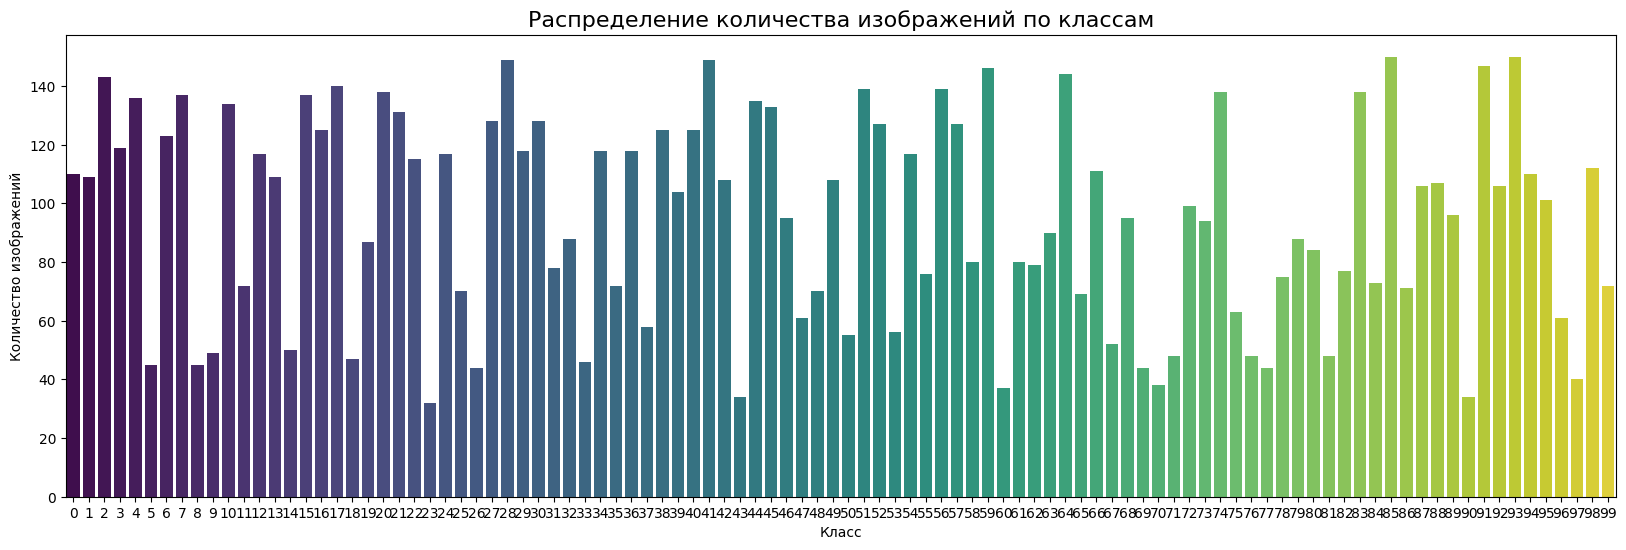

Минимум примеров в классе: 32
Максимум примеров в классе: 150
Среднее количество примеров в классе: 95.10


In [11]:
#график
plt.figure(figsize=(20, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Распределение количества изображений по классам", fontsize=16)
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.show()
print(f"Минимум примеров в классе: {class_counts.min()}")
print(f"Максимум примеров в классе: {class_counts.max()}")
print(f"Среднее количество примеров в классе: {class_counts.mean():.2f}")


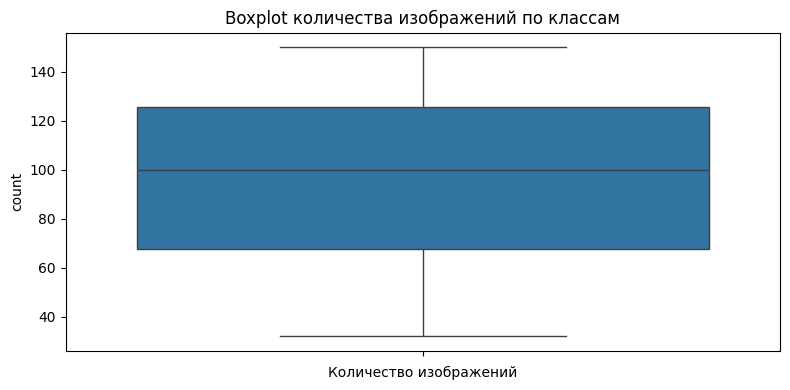

In [12]:
# Boxplot распределения
plt.figure(figsize=(8, 4))
sns.boxplot(data=class_counts)
plt.title('Boxplot количества изображений по классам')
plt.xlabel('Количество изображений')
plt.tight_layout()
plt.show()

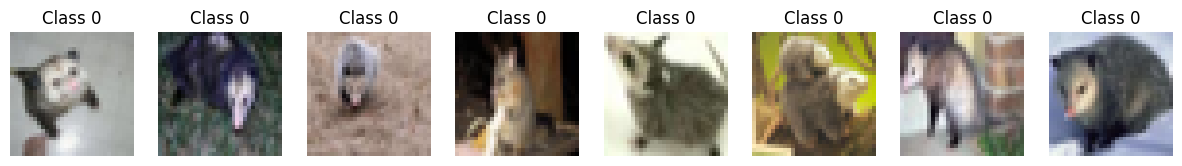

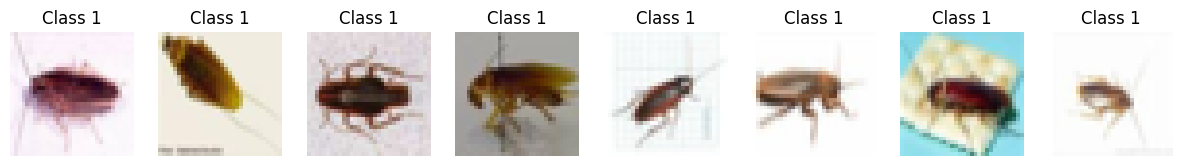

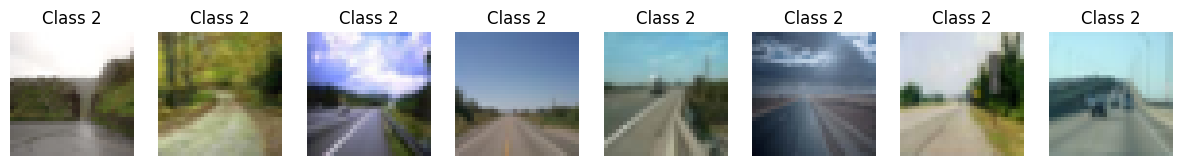

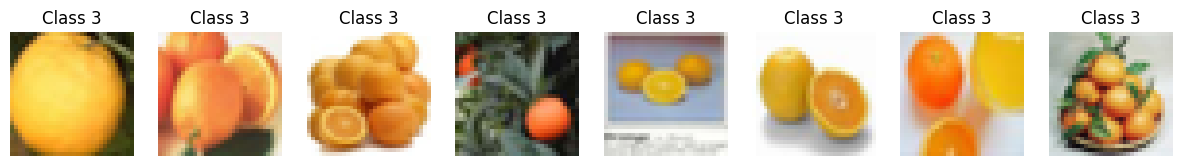

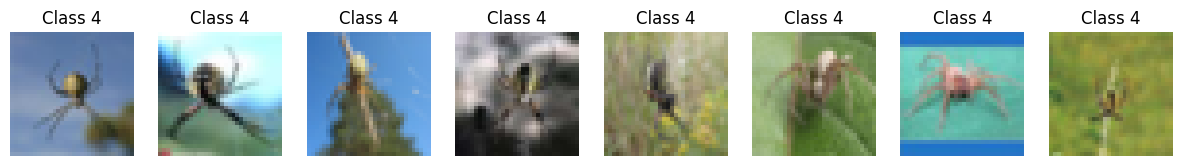

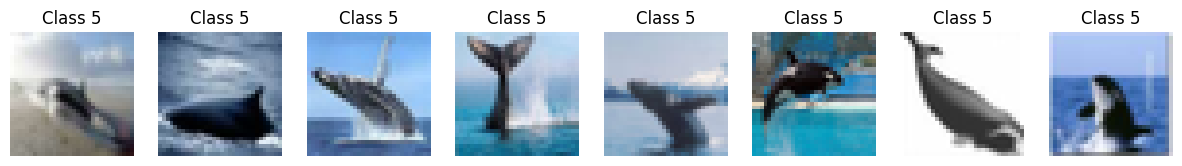

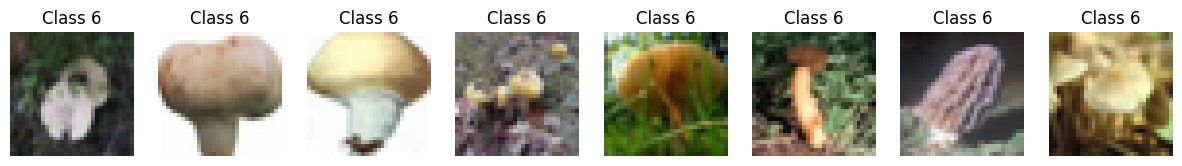

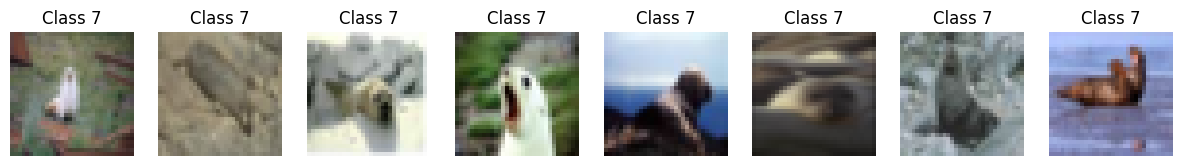

In [13]:
def show_images_for_class(class_label, num_images=8):
    img_ids = train_labels[train_labels['target'] == class_label]['id'].values
    plt.figure(figsize=(15, 8))
    for i, img_id in enumerate(img_ids[:num_images]):
        img_path = os.path.join(train_path, str(class_label), img_id + ".png")
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Class {class_label}")
    plt.show()

# Примеры для нескольких классов
for cls in [0, 1, 2, 3, 4, 5, 6, 7]:
    show_images_for_class(cls)


In [14]:
train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels['target'], random_state=42)

print(f"Трейн: {len(train_df)}, Валидация: {len(val_df)}")

Трейн: 7608, Валидация: 1902


In [42]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, data_path, transform=None):
        self.dataframe = dataframe
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx]['id']
        label = self.dataframe.iloc[idx]['target']

        img_path = os.path.join(self.data_path, str(label), img_id + ".png")
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label


In [43]:
#Аугментации
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-43-5167ab811212>:9: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
<ipython-input-43-5167ab811212>:10: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),


In [45]:
batch_size = 64

train_dataset = CustomDataset(train_df, train_path, transform=train_transform)
val_dataset = CustomDataset(val_df, train_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)



In [46]:
#Модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, train_labels['target'].nunique())
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels['target']), y=train_labels['target'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Добавляем scheduler и early stopping
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


In [48]:
def train_one_epoch(model, optimizer, criterion, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / len(train_loader.dataset)
    return epoch_loss, epoch_acc

def validate_one_epoch(model, criterion, val_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / len(val_loader.dataset)
    return epoch_loss, epoch_acc


In [49]:
# --- Обучение ---
num_epochs = 15
best_val_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
    val_loss, val_acc = validate_one_epoch(model, criterion, val_loader, device)
    scheduler.step(val_loss)

    print(f"\nЭпоха [{epoch}/{num_epochs}]")
    print(f"Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")
    print(f"Val loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Лучшая модель сохранена!")



Эпоха [1/15]
Train loss: 4.4178, accuracy: 0.0498
Val loss: 4.6821, accuracy: 0.0431
Лучшая модель сохранена!

Эпоха [2/15]
Train loss: 3.8343, accuracy: 0.1073
Val loss: 3.6048, accuracy: 0.1393
Лучшая модель сохранена!

Эпоха [3/15]
Train loss: 3.4413, accuracy: 0.1643
Val loss: 3.7245, accuracy: 0.1535

Эпоха [4/15]
Train loss: 3.1377, accuracy: 0.2196
Val loss: 2.9468, accuracy: 0.2534
Лучшая модель сохранена!

Эпоха [5/15]
Train loss: 2.8836, accuracy: 0.2647
Val loss: 3.1354, accuracy: 0.2529

Эпоха [6/15]
Train loss: 2.6668, accuracy: 0.3094
Val loss: 2.7541, accuracy: 0.3076
Лучшая модель сохранена!

Эпоха [7/15]
Train loss: 2.5066, accuracy: 0.3429
Val loss: 2.7675, accuracy: 0.3265

Эпоха [8/15]
Train loss: 2.3447, accuracy: 0.3687
Val loss: 2.9673, accuracy: 0.3286

Эпоха [9/15]
Train loss: 2.1938, accuracy: 0.4089
Val loss: 2.5150, accuracy: 0.3785
Лучшая модель сохранена!

Эпоха [10/15]
Train loss: 2.0826, accuracy: 0.4255
Val loss: 2.4727, accuracy: 0.4001
Лучшая модель 

In [54]:
!pip install efficientnet-pytorch timm albumentations tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=0d13cc1221d989600fbf2a338d07731a7f7dd2aa66ae019c

вот это похоже запускать

In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import seaborn as sns
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from torchvision import transforms, datasets
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
from efficientnet_pytorch import EfficientNet
import timm

In [56]:
# Улучшенные функции обучения и валидации
def train_one_epoch(model, optimizer, criterion, train_loader, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        progress_bar.set_postfix({
            'loss': running_loss/total,
            'acc': correct/total
        })

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_one_epoch(model, criterion, val_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(val_loader, desc='Validation', leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix({
                'loss': running_loss/total,
                'acc': correct/total
            })

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Функция создания модели с автоматической загрузкой весов
def create_model(model_name, num_classes):
    if model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'efficientnet':
        model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=num_classes)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model.to(device)

# Основной цикл обучения
def train_model(model_name, train_loader, val_loader, num_classes, num_epochs=20):
    print(f"\n=== Training {model_name} ===")

    model = create_model(model_name, num_classes)

    # Взвешенная loss function для дисбаланса классов
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_labels['target']),
        y=train_labels['target']
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs
    )

    best_acc = 0.0
    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        train_loss, train_acc = train_one_epoch(
            model, optimizer, criterion, train_loader, device, scheduler
        )
        val_loss, val_acc = validate_one_epoch(
            model, criterion, val_loader, device
        )

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_{model_name}.pth")
            print(f"New best model saved with val_acc: {best_acc:.4f}")

    print(f"\nBest validation accuracy for {model_name}: {best_acc:.4f}")
    return best_acc

# Параметры
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = train_labels['target'].nunique()
models_to_try = ['resnet50', 'efficientnet', 'efficientnet_v2']

# Запуск обучения для всех моделей
results = {}
for model_name in models_to_try:
    results[model_name] = train_model(
        model_name,
        train_loader,
        val_loader,
        num_classes
    )

# Вывод результатов
print("\n=== Final Results ===")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")


=== Training resnet50 ===

Epoch 1/20


Train Loss: 4.2594 | Acc: 0.0933
Val Loss: 2.9991 | Acc: 0.3118
New best model saved with val_acc: 0.3118

Epoch 2/20


Train Loss: 2.9525 | Acc: 0.2850
Val Loss: 2.3652 | Acc: 0.3644
New best model saved with val_acc: 0.3644

Epoch 3/20


Train Loss: 2.7792 | Acc: 0.3019
Val Loss: 2.9320 | Acc: 0.3013

Epoch 4/20


Train Loss: 2.9067 | Acc: 0.2764
Val Loss: 3.1577 | Acc: 0.2760

Epoch 5/20


Train Loss: 2.8778 | Acc: 0.2865
Val Loss: 3.6368 | Acc: 0.2287

Epoch 6/20


Train Loss: 2.6989 | Acc: 0.3064
Val Loss: 3.4922 | Acc: 0.2629

Epoch 7/20


Train Loss: 2.5545 | Acc: 0.3343
Val Loss: 2.6524 | Acc: 0.3486

Epoch 8/20


Train Loss: 2.3431 | Acc: 0.3818
Val Loss: 2.4762 | Acc: 0.3775
New best model saved with val_acc: 0.3775

Epoch 9/20


Train Loss: 2.1950 | Acc: 0.4076
Val Loss: 2.4724 | Acc: 0.3722

Epoch 10/20


Train Loss: 1.9548 | Acc: 0.4549
Val Loss: 2.1577 | Acc: 0.4359
New best model saved with val_acc: 0.4359

Epoch 11/20


Train Loss: 1.8040 | Acc: 0.4926
Val Loss: 2.1263 | Acc: 0.4532
New best model saved with val_acc: 0.4532

Epoch 12/20


Train Loss: 1.6748 | Acc: 0.5152
Val Loss: 2.0778 | Acc: 0.4721
New best model saved with val_acc: 0.4721

Epoch 13/20


Train Loss: 1.4936 | Acc: 0.5748
Val Loss: 1.7797 | Acc: 0.5389
New best model saved with val_acc: 0.5389

Epoch 14/20


Train Loss: 1.3043 | Acc: 0.6150
Val Loss: 1.8214 | Acc: 0.5394
New best model saved with val_acc: 0.5394

Epoch 15/20


Train Loss: 1.1423 | Acc: 0.6533
Val Loss: 1.7294 | Acc: 0.5789
New best model saved with val_acc: 0.5789

Epoch 16/20


Train Loss: 1.0130 | Acc: 0.6841
Val Loss: 1.6175 | Acc: 0.6025
New best model saved with val_acc: 0.6025

Epoch 17/20


Train Loss: 0.8761 | Acc: 0.7245
Val Loss: 1.6131 | Acc: 0.5936

Epoch 18/20


Train Loss: 0.7892 | Acc: 0.7538
Val Loss: 1.5636 | Acc: 0.6130
New best model saved with val_acc: 0.6130

Epoch 19/20


Train Loss: 0.7216 | Acc: 0.7722
Val Loss: 1.5508 | Acc: 0.6167
New best model saved with val_acc: 0.6167

Epoch 20/20


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


Train Loss: 0.7003 | Acc: 0.7834
Val Loss: 1.5564 | Acc: 0.6141

Best validation accuracy for resnet50: 0.6167

=== Training efficientnet ===


100%|██████████| 47.1M/47.1M [00:00<00:00, 209MB/s]


Loaded pretrained weights for efficientnet-b3

Epoch 1/20


Train Loss: 4.5751 | Acc: 0.0276
Val Loss: 4.4038 | Acc: 0.1372
New best model saved with val_acc: 0.1372

Epoch 2/20


Train Loss: 4.0354 | Acc: 0.1703
Val Loss: 2.6052 | Acc: 0.3959
New best model saved with val_acc: 0.3959

Epoch 3/20


Train Loss: 2.5422 | Acc: 0.3908
Val Loss: 1.8147 | Acc: 0.5484
New best model saved with val_acc: 0.5484

Epoch 4/20


Train Loss: 1.9823 | Acc: 0.4819
Val Loss: 2.0822 | Acc: 0.5147

Epoch 5/20


Train Loss: 1.7980 | Acc: 0.5095
Val Loss: 1.9996 | Acc: 0.5110

Epoch 6/20


Train Loss: 1.5942 | Acc: 0.5599
Val Loss: 1.8861 | Acc: 0.5326

Epoch 7/20


Train Loss: 1.3449 | Acc: 0.6195
Val Loss: 1.9493 | Acc: 0.5400

Epoch 8/20


Train Loss: 1.2212 | Acc: 0.6527
Val Loss: 2.0143 | Acc: 0.5389

Epoch 9/20


Train Loss: 1.0030 | Acc: 0.7020
Val Loss: 1.5967 | Acc: 0.6183
New best model saved with val_acc: 0.6183

Epoch 10/20


Train Loss: 0.8261 | Acc: 0.7500
Val Loss: 1.5158 | Acc: 0.6309
New best model saved with val_acc: 0.6309

Epoch 11/20


Train Loss: 0.7043 | Acc: 0.7797
Val Loss: 1.3876 | Acc: 0.6730
New best model saved with val_acc: 0.6730

Epoch 12/20


Train Loss: 0.5750 | Acc: 0.8239
Val Loss: 1.3682 | Acc: 0.6961
New best model saved with val_acc: 0.6961

Epoch 13/20


Train Loss: 0.4196 | Acc: 0.8667
Val Loss: 1.3343 | Acc: 0.7003
New best model saved with val_acc: 0.7003

Epoch 14/20


Train Loss: 0.3391 | Acc: 0.8933
Val Loss: 1.2411 | Acc: 0.7266
New best model saved with val_acc: 0.7266

Epoch 15/20


Train Loss: 0.2791 | Acc: 0.9132
Val Loss: 1.2611 | Acc: 0.7303
New best model saved with val_acc: 0.7303

Epoch 16/20


Train Loss: 0.2053 | Acc: 0.9348
Val Loss: 1.2289 | Acc: 0.7345
New best model saved with val_acc: 0.7345

Epoch 17/20


Train Loss: 0.1804 | Acc: 0.9416
Val Loss: 1.2391 | Acc: 0.7366
New best model saved with val_acc: 0.7366

Epoch 18/20


Train Loss: 0.1732 | Acc: 0.9469
Val Loss: 1.2274 | Acc: 0.7382
New best model saved with val_acc: 0.7382

Epoch 19/20


Train Loss: 0.1510 | Acc: 0.9552
Val Loss: 1.2318 | Acc: 0.7382

Epoch 20/20


Train Loss: 0.1543 | Acc: 0.9532
Val Loss: 1.2345 | Acc: 0.7387
New best model saved with val_acc: 0.7387

Best validation accuracy for efficientnet: 0.7387

=== Training efficientnet_v2 ===


NameError: name 'timm' is not defined

короче тут я забыла импортить timm, оно очень долго обучалось, поэтому я решила не перезапускать, и залила в лидерборд с весами efficientnet

In [61]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=num_classes)
model.load_state_dict(torch.load('best_efficientnet.pth'))
model = model.to(device)
model.eval()

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [64]:
predictions = []
ids = []

with torch.no_grad():
    for images, batch_ids in tqdm(test_loader, desc='Making predictions'):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.cpu().numpy())
        ids.extend(batch_ids)

# 4. Создание submission файла
submission = pd.DataFrame({
    'id': ids,
    'target': predictions
})

# Если нужно сортировать по ID как в sample_submission:
if 'sample_submission.csv' in os.listdir():
    sample = pd.read_csv('sample_submission.csv')
    submission = submission.set_index('id').reindex(sample['id']).reset_index()

# Сохранение
submission.to_csv('submission.csv', index=False)
print("Submission file saved successfully!")
print(submission.head())



Making predictions: 100%|██████████| 61/61 [00:14<00:00,  4.10it/s]


Submission file saved successfully!
     id  target
0  2335      85
1   766      39
2  2713      77
3   856      56
4  1500      53


я отдельно попробовала третью модель, она дала такой же скор, я успокоилась)